In [1]:
import sys
from scipy.odr import *
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import numpy as np; from matplotlib.pyplot import *
import fileread as fr; import predefined as pd; import wave_ops as wo
from scipy.optimize import curve_fit; from scipy.signal import fftconvolve
import pickle

dataloc='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/calib_src_runs/'
simloc= '/home/noah/Desktop/large_analysis/zeck_simulation/'

sndata=np.concatenate((pd.precuts(fr.gen_output(dataloc+'Run_131-all.dat')[0]),\
                       pd.precuts(fr.gen_output(dataloc+'Run_132-all.dat')[0])))
bidata=np.concatenate((pd.precuts(fr.gen_output(dataloc+'Run_136-all.dat')[0]),\
                       pd.precuts(fr.gen_output(dataloc+'Run_137-all.dat')[0])))
cedata=np.concatenate((pd.precuts(fr.gen_output(dataloc+'Run_133-all.dat')[0]),\
                       pd.precuts(fr.gen_output(dataloc+'/Run_134-all.dat')[0])))

sndata,bidata,cedata=sndata.view(np.recarray),bidata.view(np.recarray),cedata.view(np.recarray)
sndata.energy,bidata.energy=pd.vec_calibrate(sndata.energy,sndata.board,sndata.channel),pd.vec_calibrate(bidata.energy,bidata.board,bidata.channel)
cedata.energy=pd.vec_calibrate(cedata.energy,cedata.board,cedata.channel)

snsim=np.load(simloc+'snbpdip/113Sn-single_event.npy')
bisim=np.load(simloc+'bibpdip/207Bi-single_event.npy')
cesim=np.load(simloc+'cebpdip/139Ce-single_event.npy')

with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)

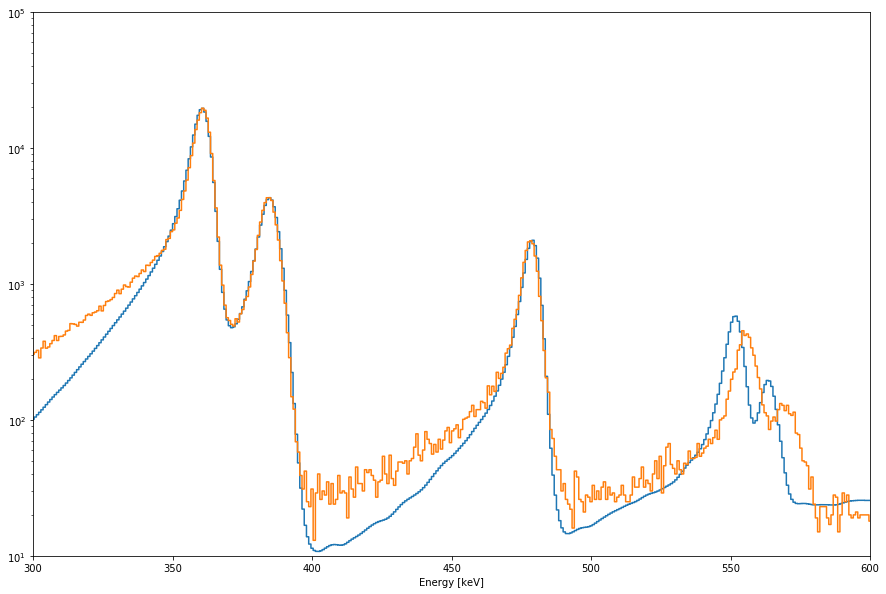

In [3]:
figure(figsize=(15,10))
h,bins=np.histogram((),bins=1000,range=[0,800])
dh,bins=np.histogram((),bins=1000,range=[0,800])
h=h.astype(float)
dh=dh.astype(float)
for bdch in [11,12,35,6]:
    bd,ch=int(bdch/8),int(bdch%8)
    sigma=detector_response[bdch]
    mu=400
    hist,bins=np.histogram(pd.sim_single_pixel(snsim,bd,ch)['energy'],bins=1000,range=[0,800])
    bins=pd.cbins(bins)
    hist=fftconvolve(hist,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]
    trutharray=(sndata.board==bd)*(sndata.channel==ch)
    dhist,bins=np.histogram(sndata.energy[trutharray],bins=1000,range=[0,800])
    dh+=dhist
    bins=pd.cbins(bins)
    hist*=np.amax(dhist[bins>300])/np.amax(hist[bins>300])
    h+=hist
    
    hist,bins=np.histogram(pd.sim_single_pixel(bisim,bd,ch)['energy'],bins=1000,range=[0,800])
    bins=pd.cbins(bins)
    hist=fftconvolve(hist,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]
    trutharray=(bidata.board==bd)*(bidata.channel==ch)
    dhist,bins=np.histogram(bidata.energy[trutharray],bins=1000,range=[0,800])
    dh+=dhist
    bins=pd.cbins(bins)
    hist*=np.amax(dhist[bins>300])/np.amax(hist[bins>300])
    h+=hist
plot(bins,h,label='sim',ds='steps')
plot(bins,dh,label='data',ds='steps')
yscale('log')
xlim(300,600)
ylim(1e1,1e5)
xlabel('Energy [keV]')
show()

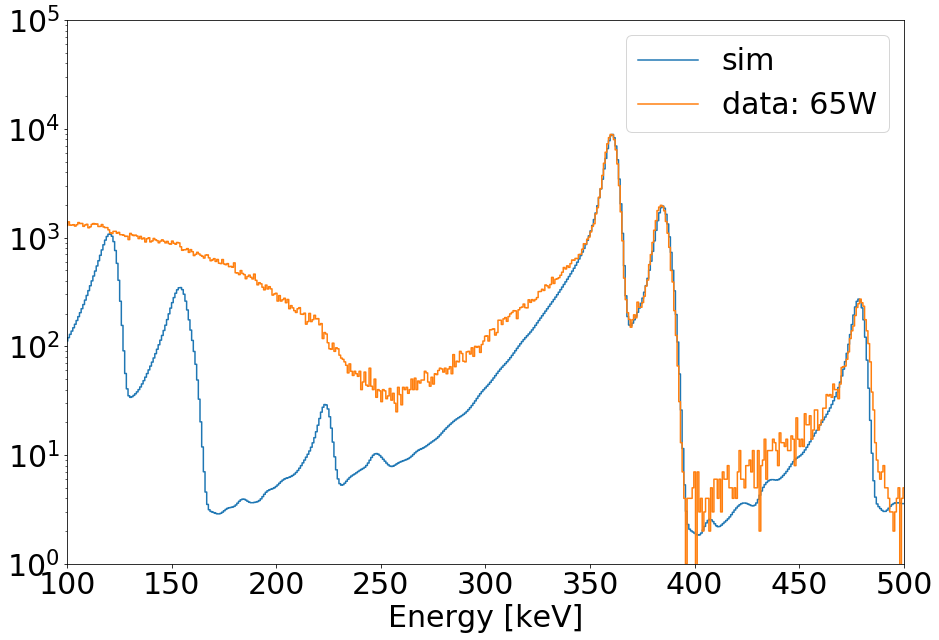

In [5]:
fs=30
figure(figsize=(15,10))
h,bins=np.histogram((),bins=1000,range=[0,800])
dh,bins=np.histogram((),bins=1000,range=[0,800])
h=h.astype(float)
dh=dh.astype(float)
bdch=12
bd,ch=int(bdch/8),int(bdch%8)
sigma=detector_response[bdch]
mu=400
hist,bins=np.histogram(pd.sim_single_pixel(snsim,bd,ch)['energy'],bins=1000,range=[0,800])
bins=pd.cbins(bins)
hist=fftconvolve(hist,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]
trutharray=(sndata.board==bd)*(sndata.channel==ch)
dhist,bins=np.histogram(sndata.energy[trutharray],bins=1000,range=[0,800])
dh+=dhist
bins=pd.cbins(bins)
hist*=np.amax(dhist[bins>300])/np.amax(hist[bins>300])
h+=hist

hist,bins=np.histogram(pd.sim_single_pixel(bisim,bd,ch)['energy'],bins=1000,range=[0,800])
bins=pd.cbins(bins)
hist=fftconvolve(hist,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]
trutharray=(bidata.board==bd)*(bidata.channel==ch)
dhist,bins=np.histogram(bidata.energy[trutharray],bins=1000,range=[0,800])
dh+=dhist
bins=pd.cbins(bins)
hist*=np.amax(dhist[bins>300])/np.amax(hist[bins>300])
h+=hist


hist,bins=np.histogram(pd.sim_single_pixel(cesim,bd,ch)['energy'],bins=1000,range=[0,800])
bins=pd.cbins(bins)
hist=fftconvolve(hist,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]
trutharray=(cedata.board==bd)*(cedata.channel==ch)
dhist,bins=np.histogram(cedata.energy[trutharray],bins=1000,range=[0,800])
dh+=dhist
bins=pd.cbins(bins)
hist*=np.amax(dhist)/np.amax(hist)
h+=hist

plot(bins,h,label='sim',ds='steps')
plot(bins,dh,label='data: '+pd.pixel(bd,ch),ds='steps')
yscale('log')
xlim(100,500)
ylim(1e0,1e5)
xlabel('Energy [keV]',fontsize=fs)
tick_params(labelsize=fs)
legend(fontsize=fs)
savefig(pd.pixel(bd,ch)+'_comb_spectra')
show()